Data haettu onnistuneesti!


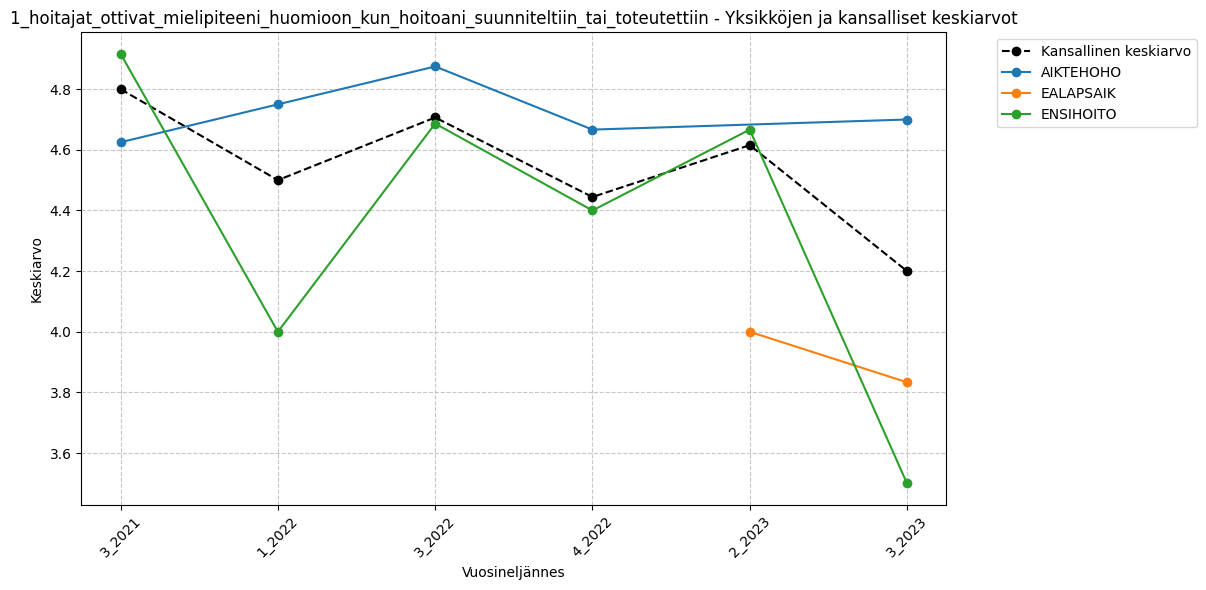

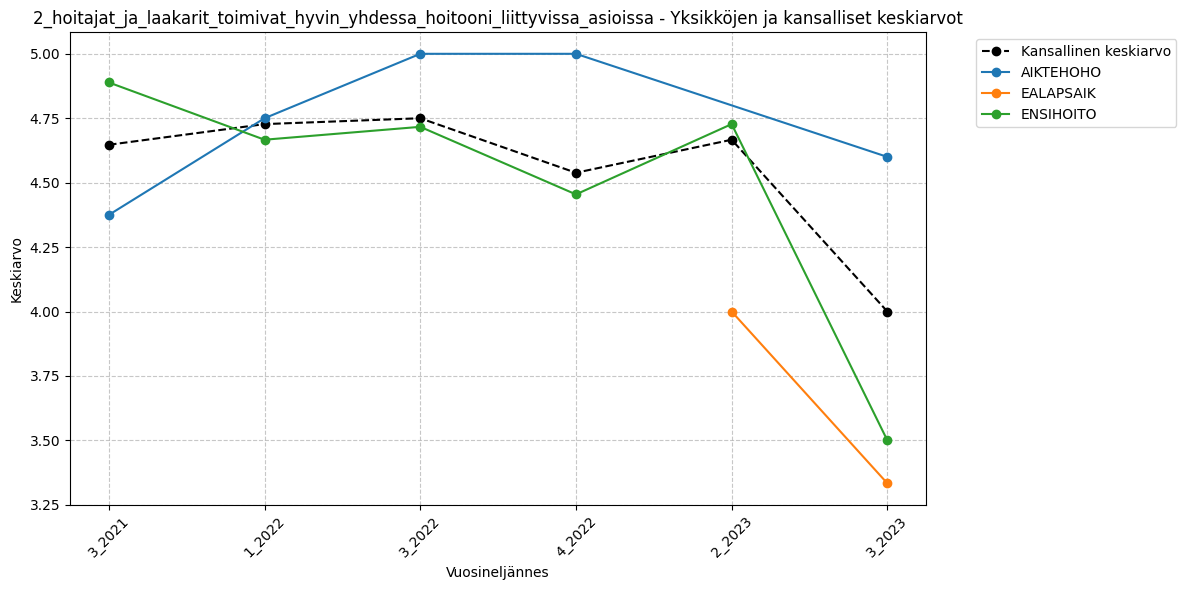

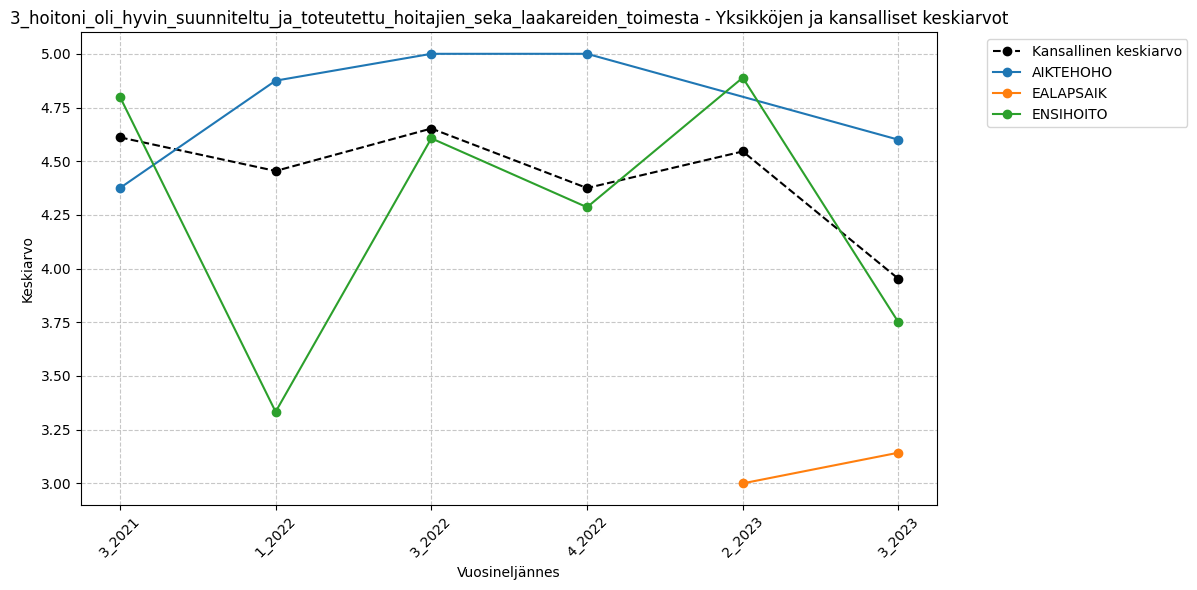

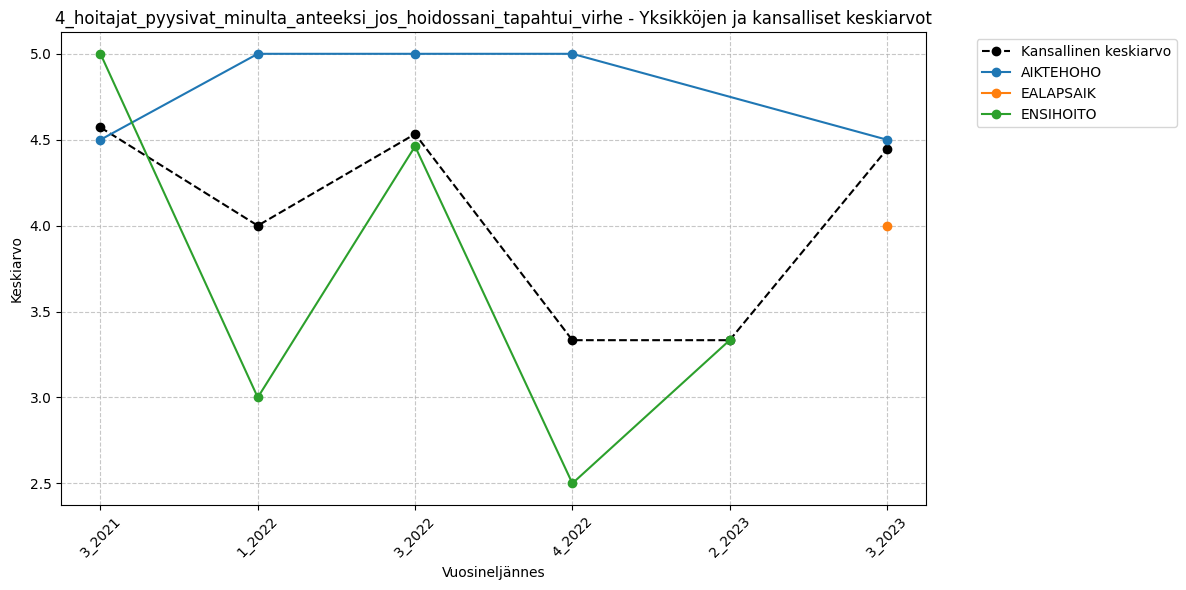

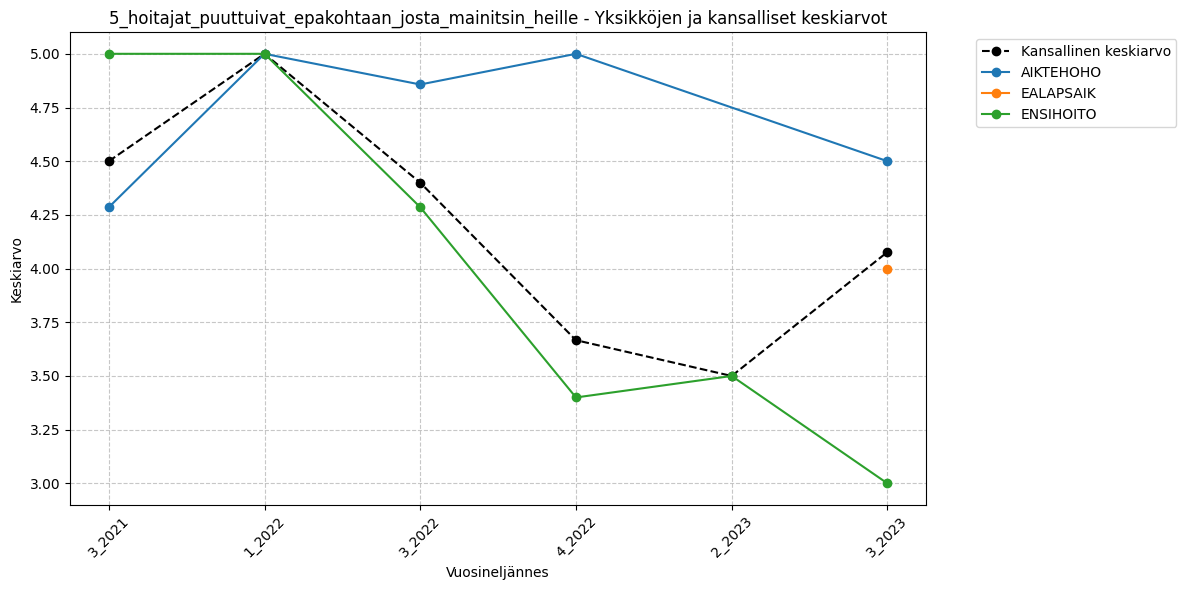

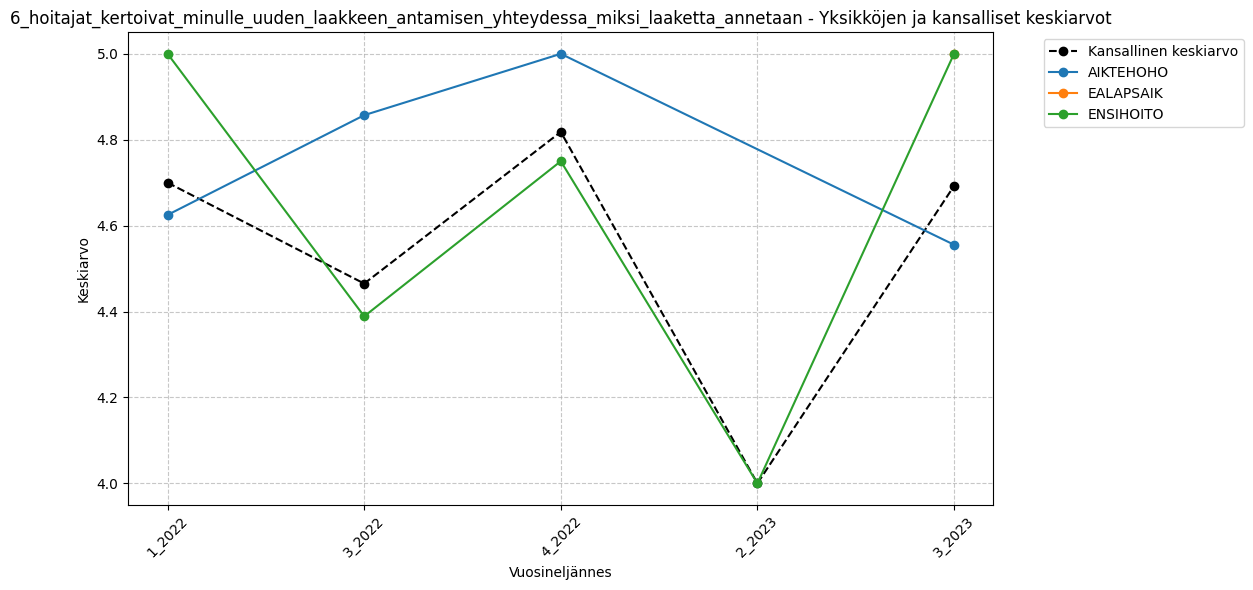

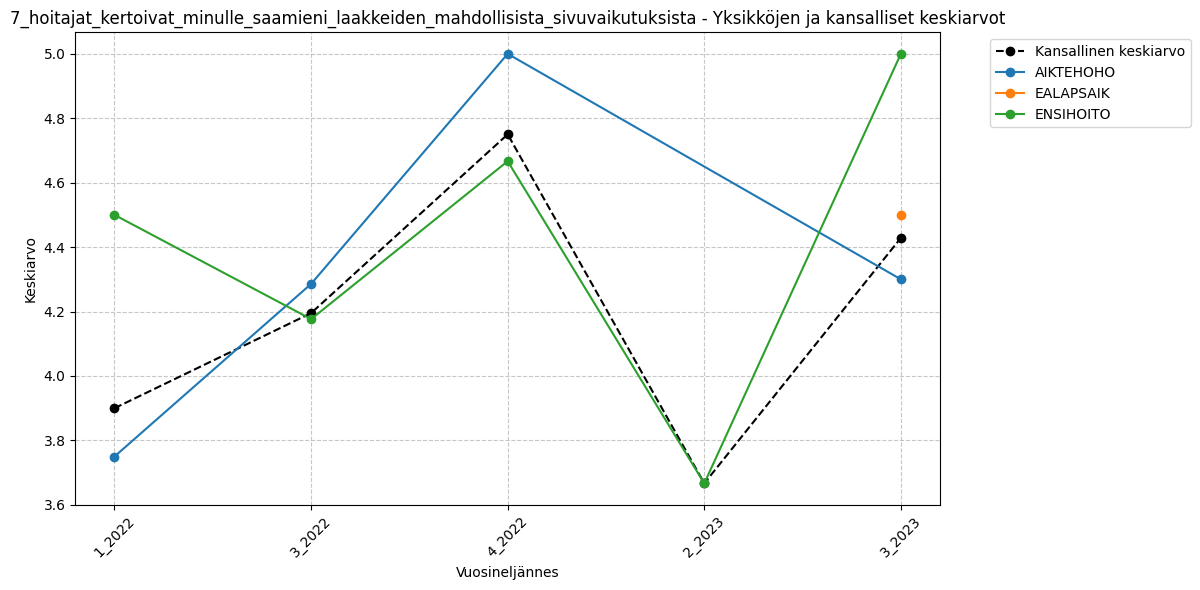

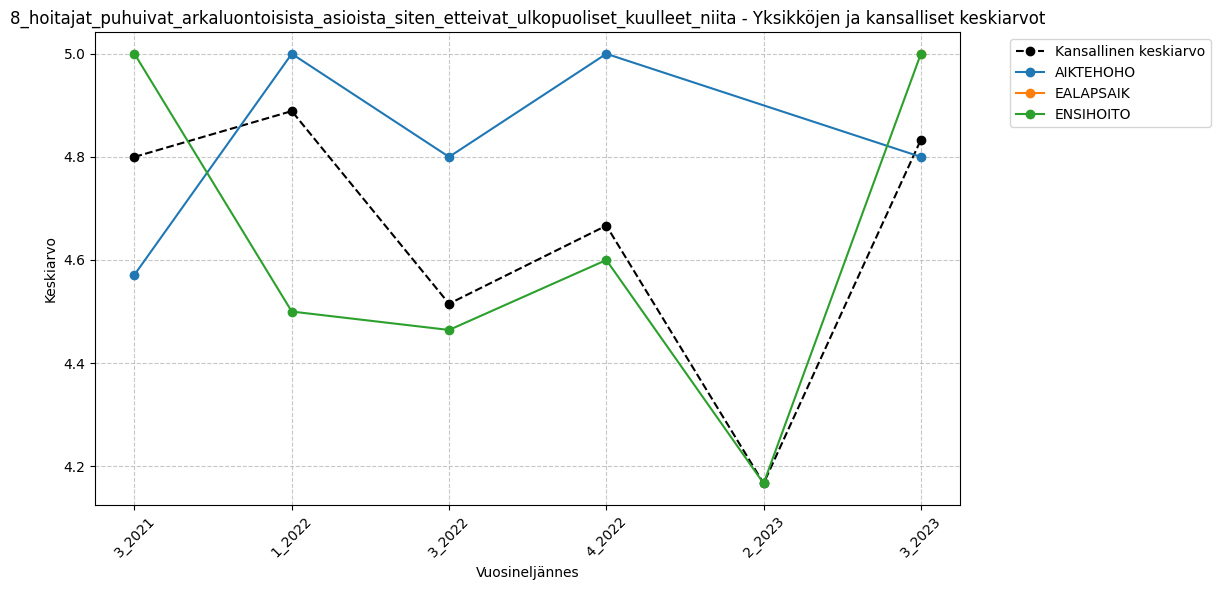

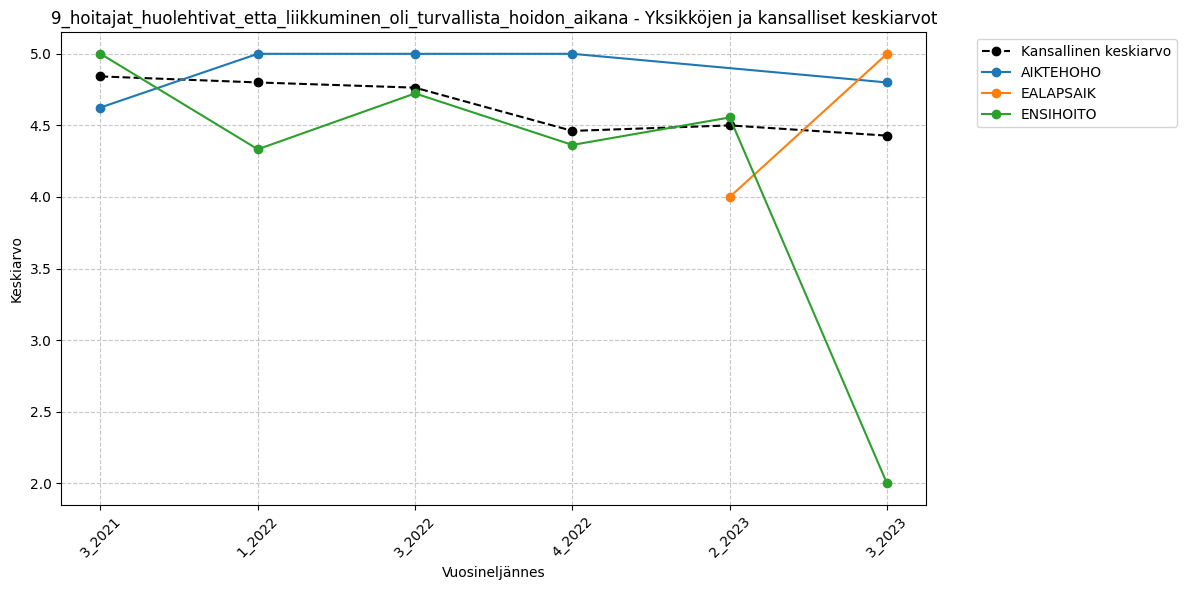

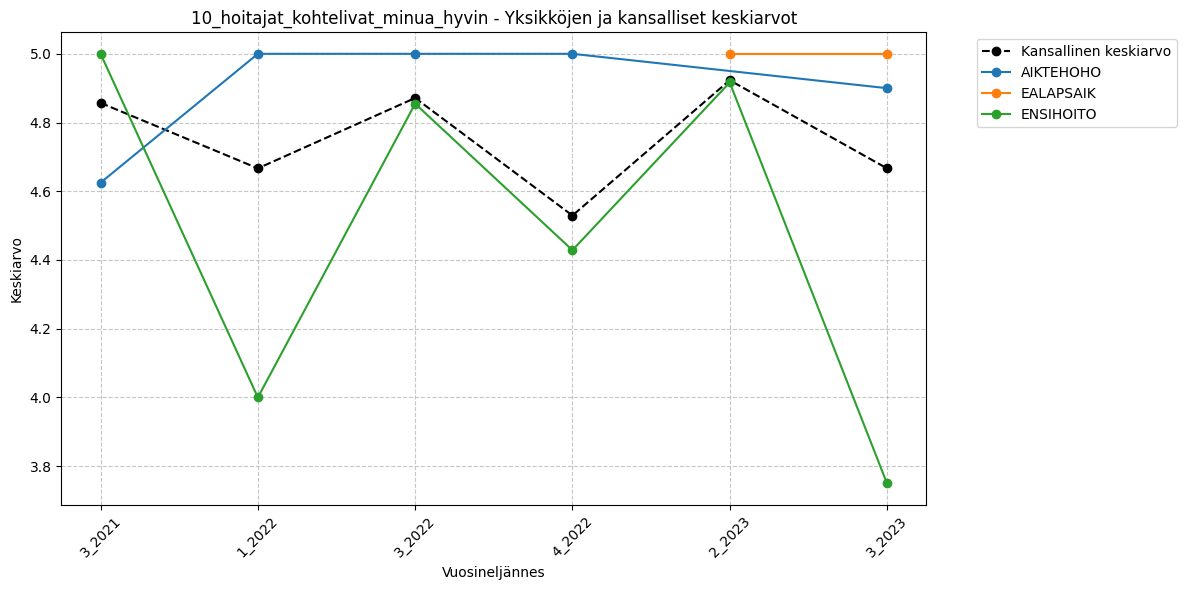

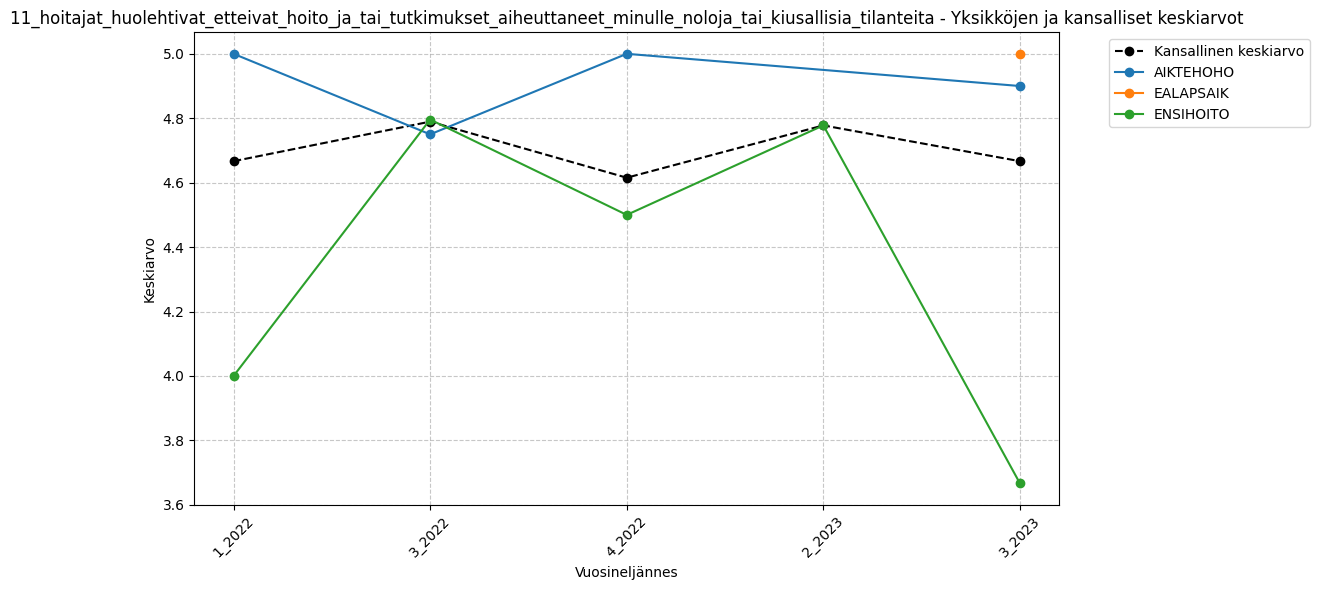

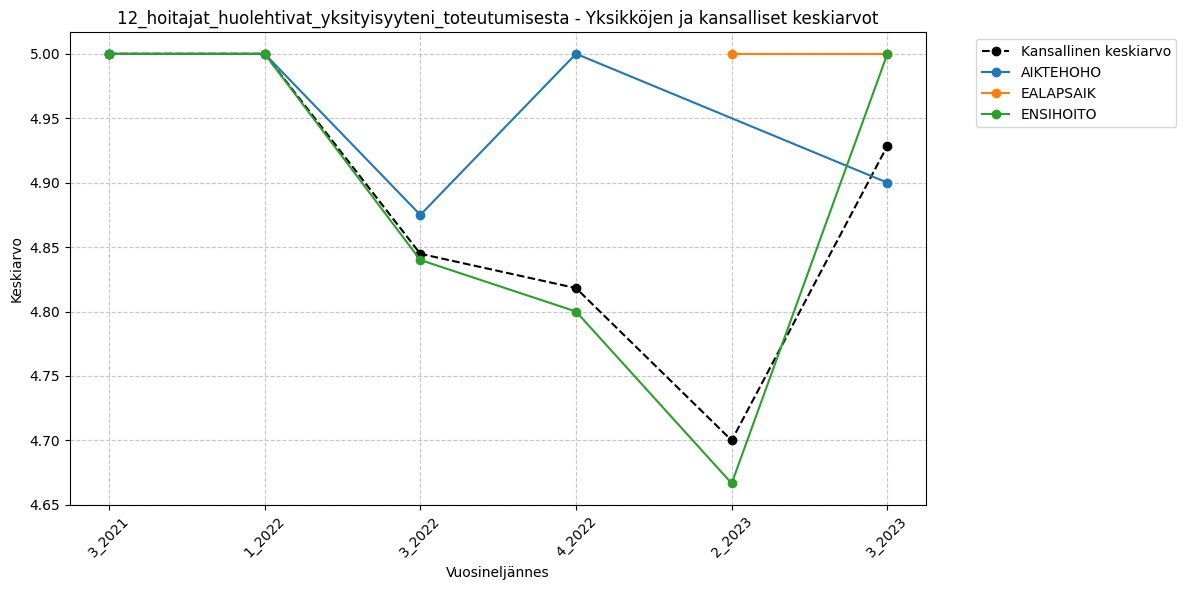

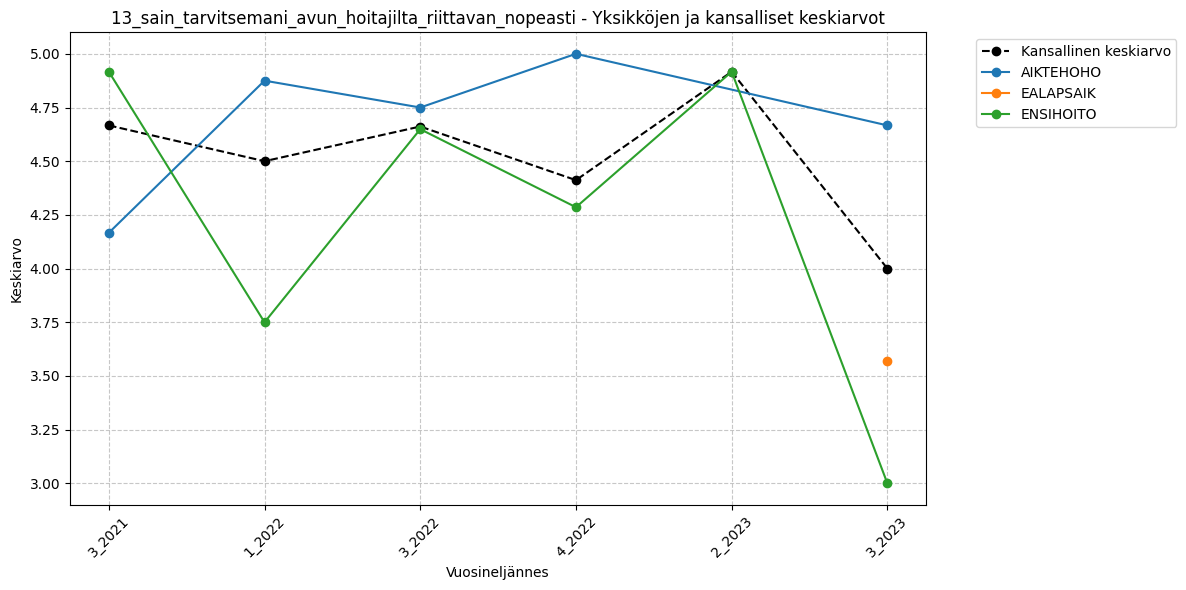

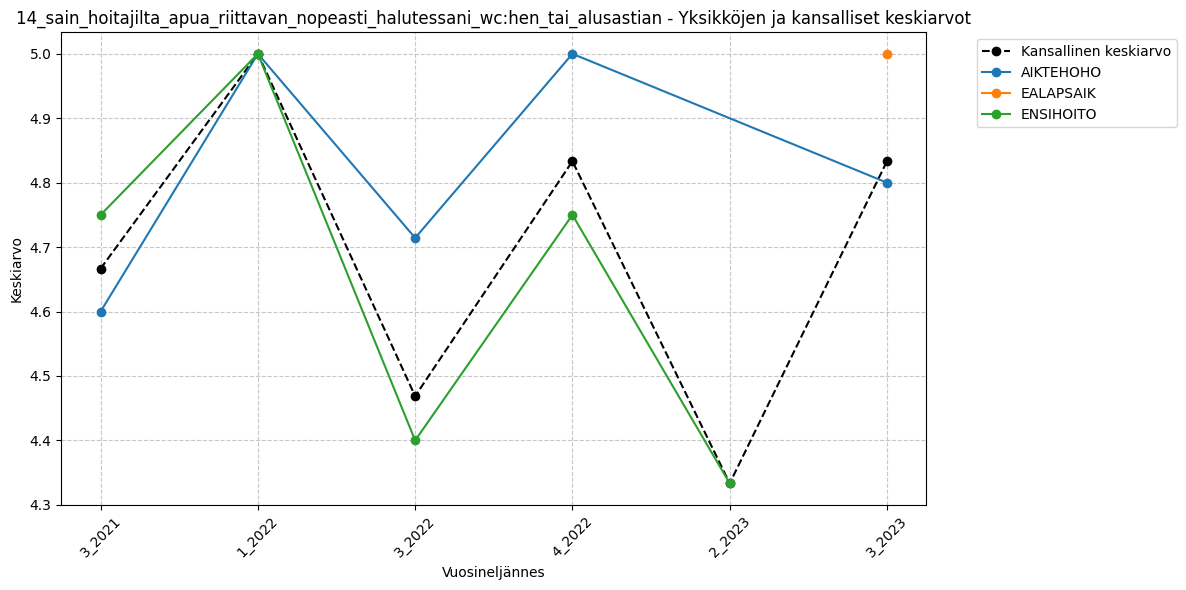

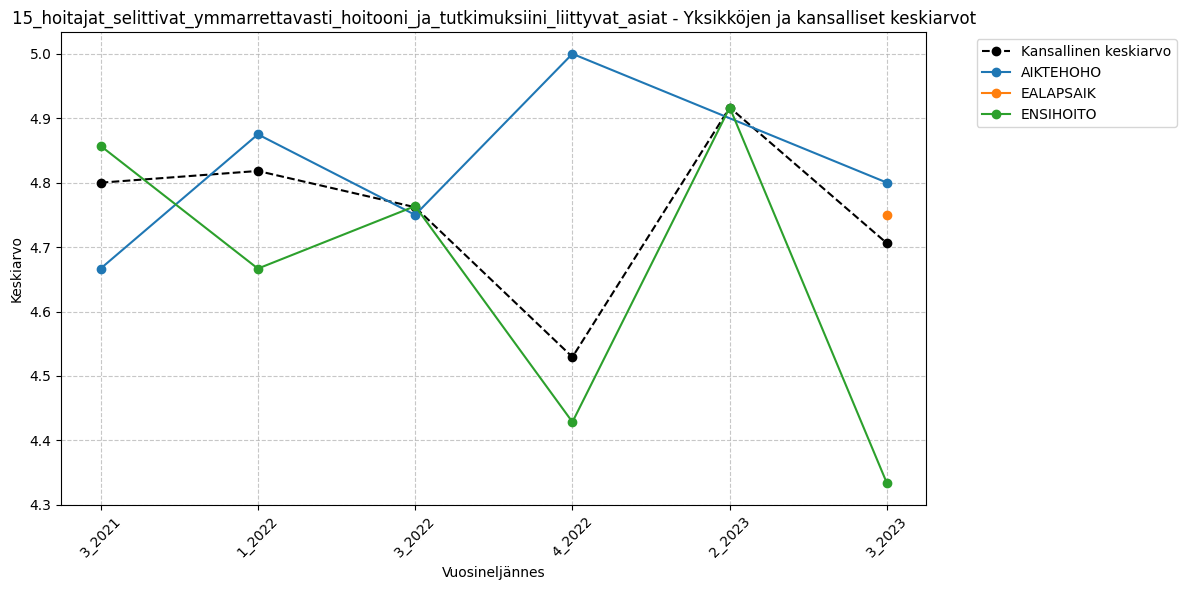

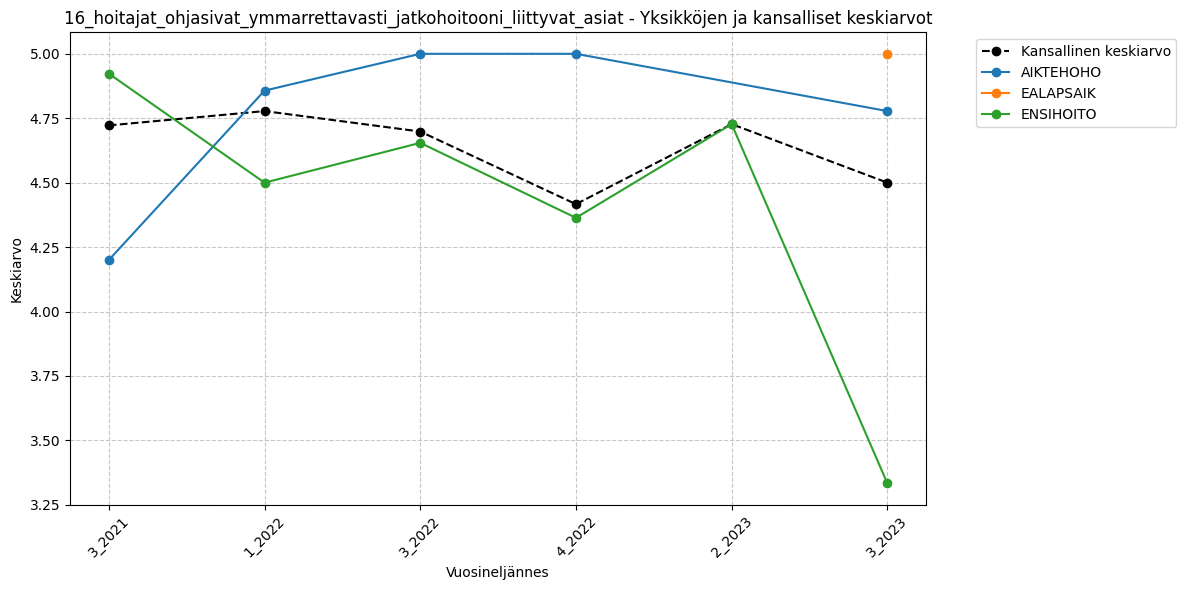

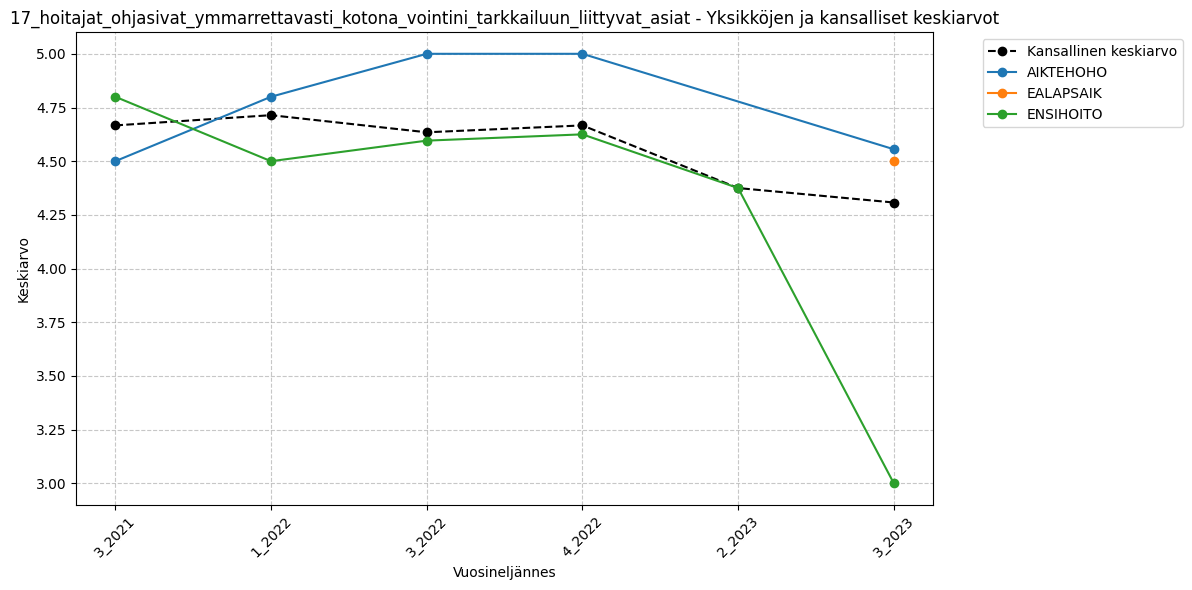

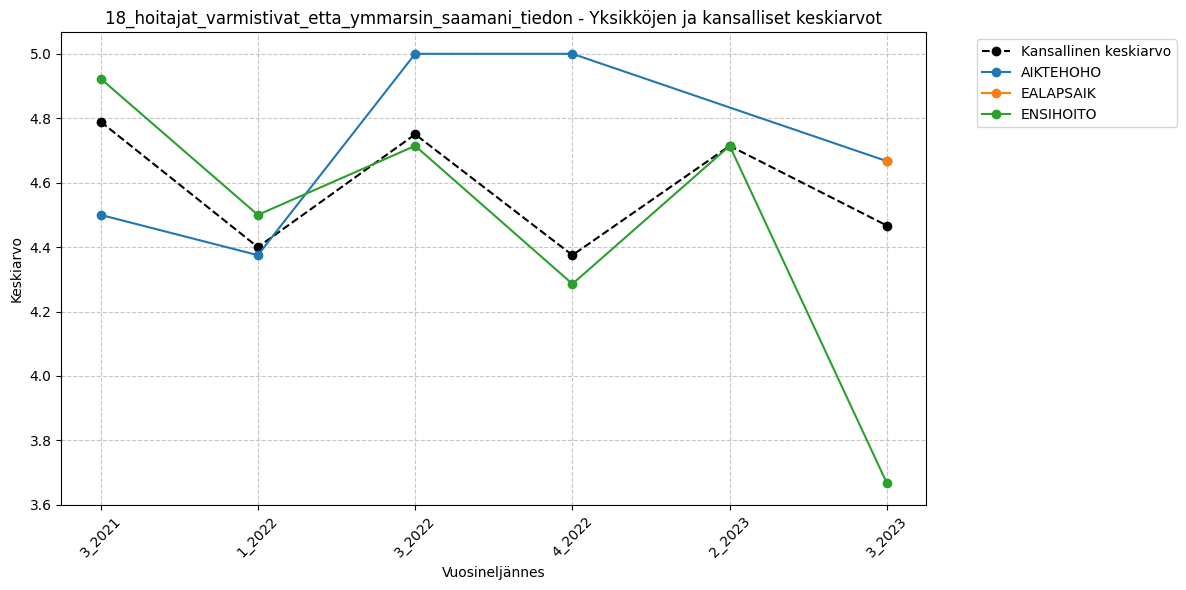

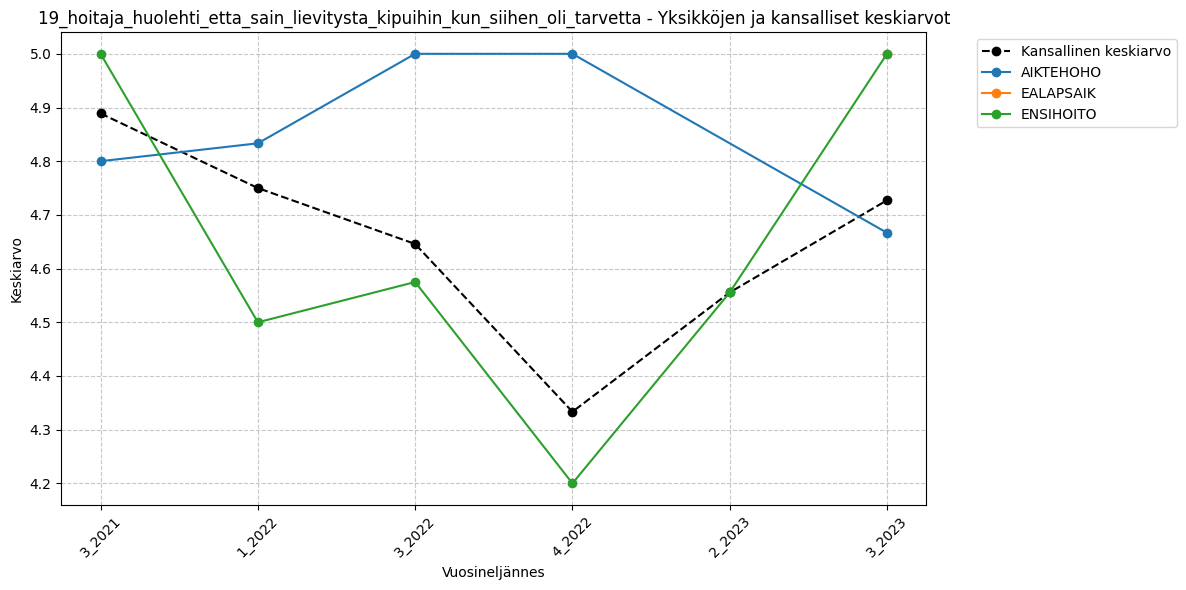

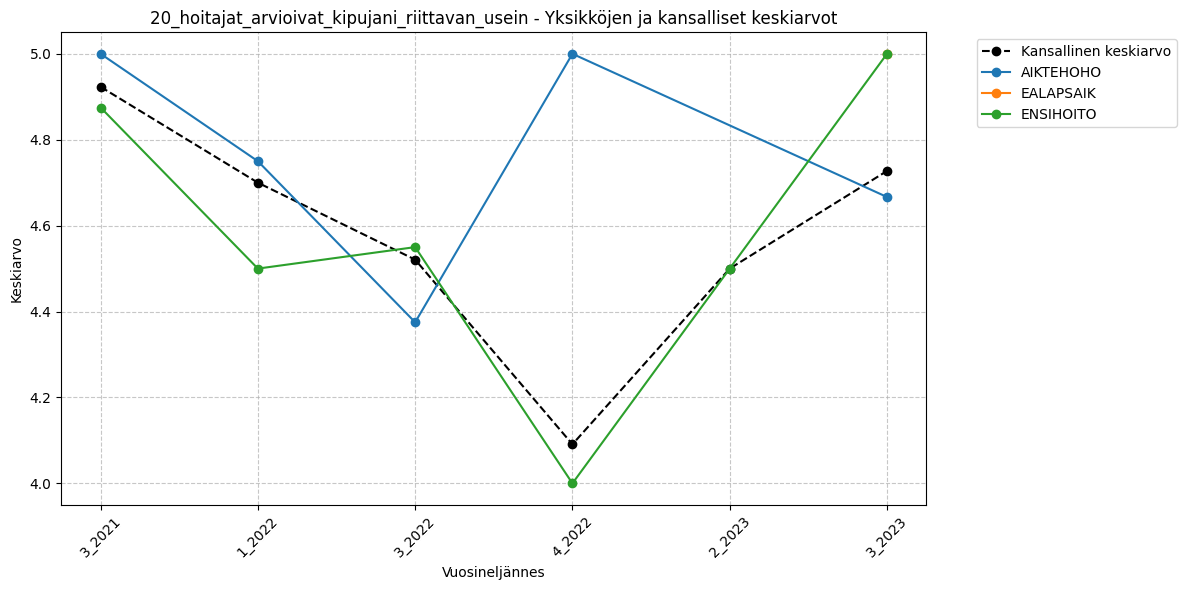

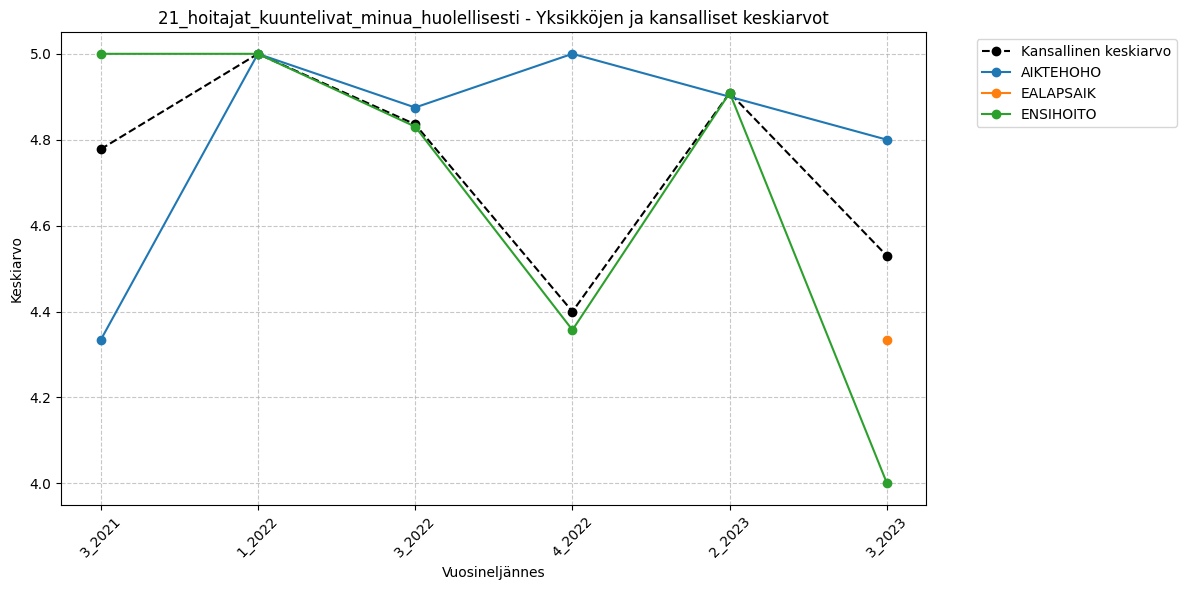

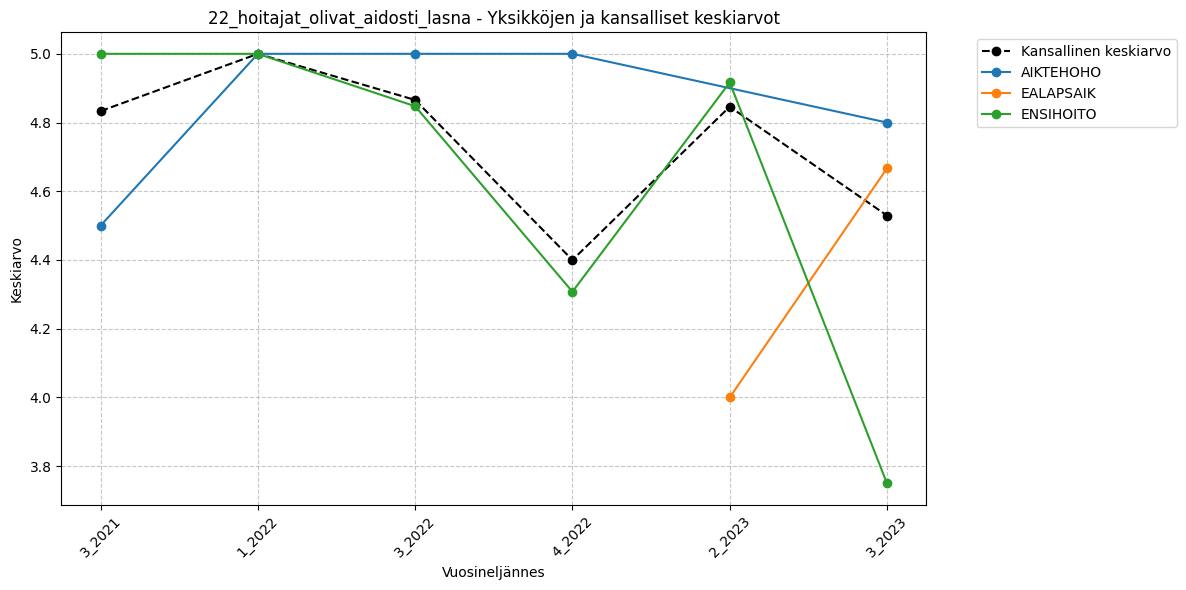

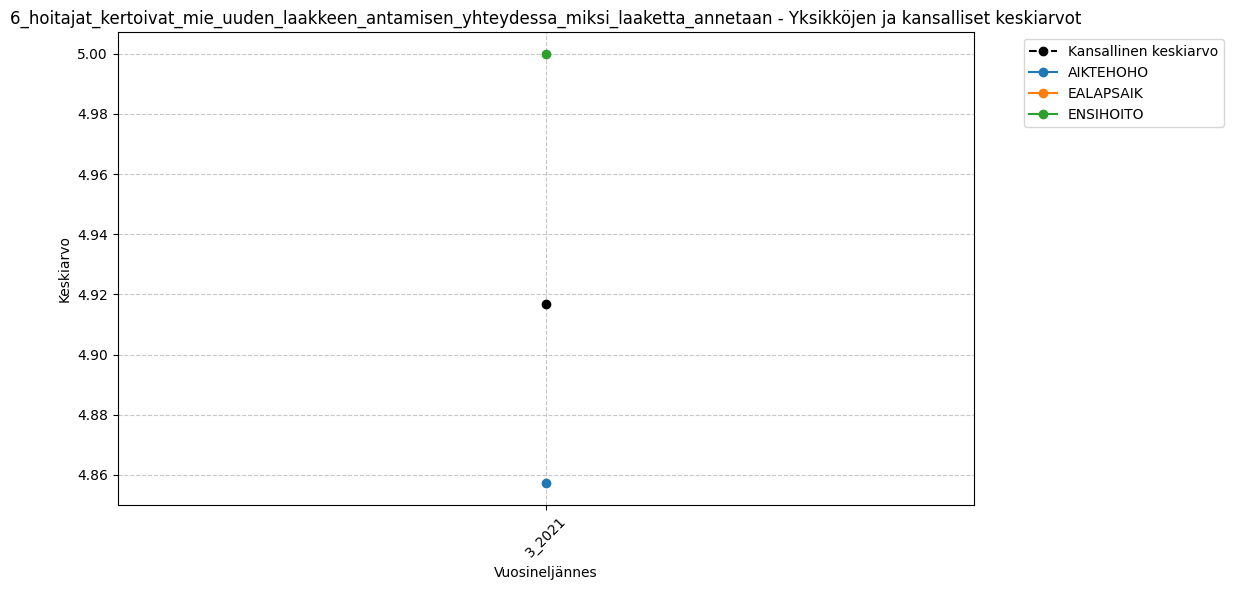

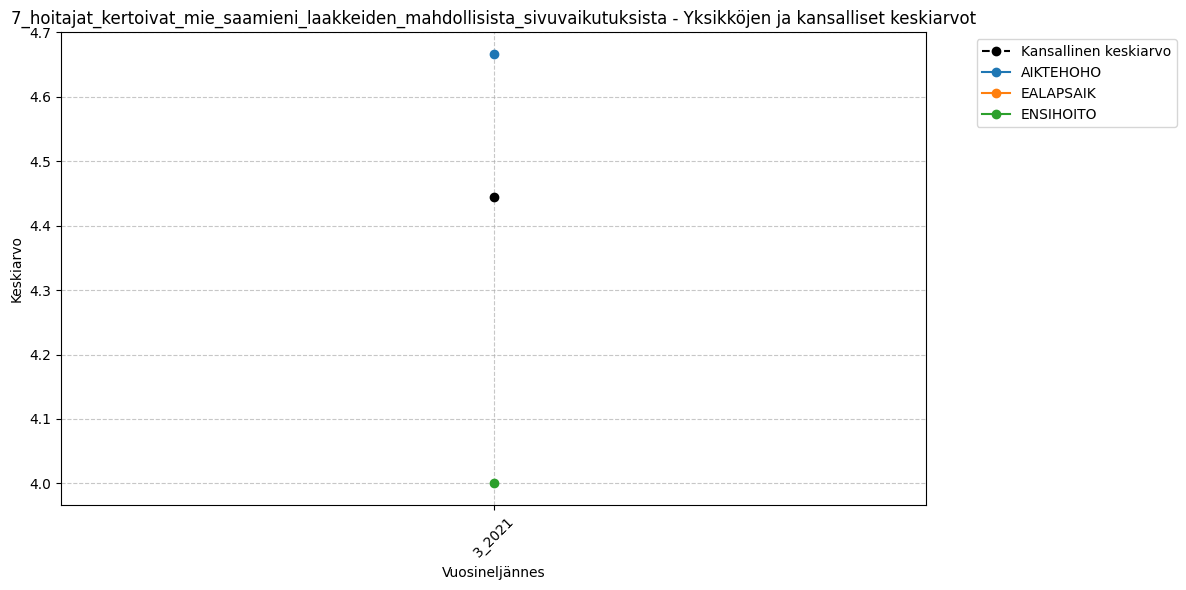

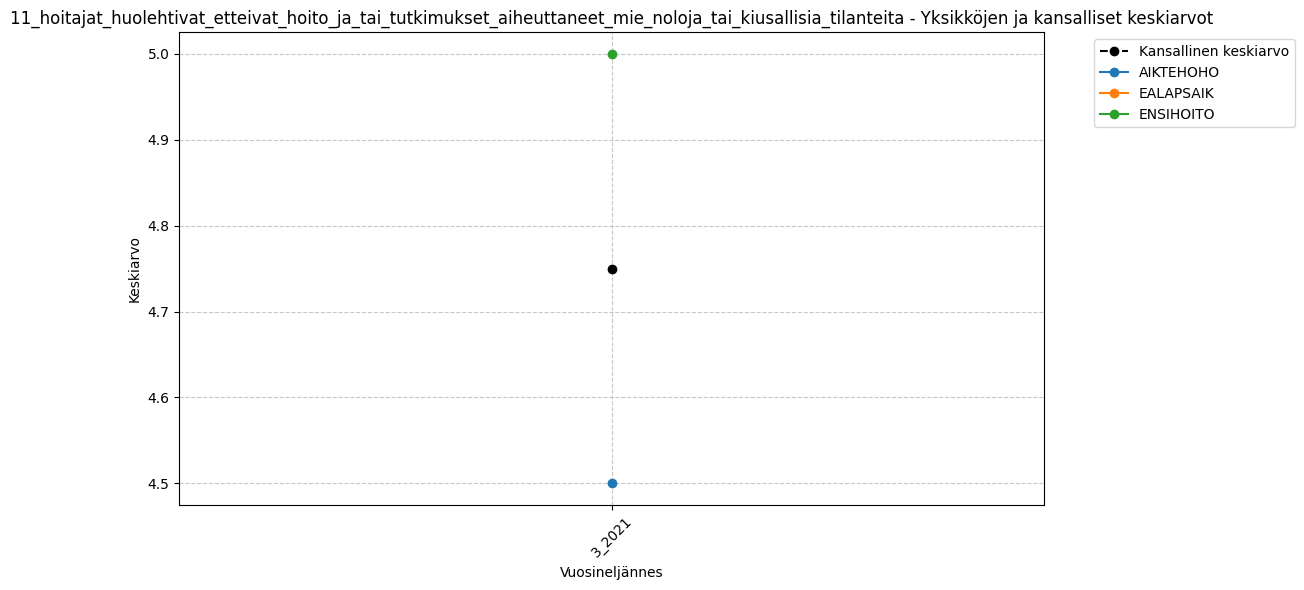

In [13]:
%matplotlib inline
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np


# API-osoite
api_url = "http://localhost:8082/get/silver/hopp"

# Tee GET-pyyntö API:lle
response = requests.get(api_url)

# Tarkista, että pyyntö onnistui
if response.status_code == 200:
    # Lataa data JSON-muodossa
    data = pd.DataFrame(response.json())
    print("Data haettu onnistuneesti!")
else:
    print(f"Virhe haettaessa dataa: {response.status_code}")
    response.raise_for_status()

# Määritä numeeriset sarakkeet (kysymykset 1-22)
numeric_columns = [col for col in data.columns if col.split('_')[0].isdigit()]

# Suodata vain halutut yksiköt
selected_units = ["AIKTEHOHO", "EALAPSAIK", "ENSIHOITO"]
data = data[data["unit_code"].isin(selected_units)]

# Korvaa 'E' arvot NaN:lla ja muunna numerot
data[numeric_columns] = data[numeric_columns].replace('E', pd.NA)
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Ryhmittele data yksikön ja vuosineljänneksen mukaan
unit_avg = data.groupby([
    'unit_code',
    'quarter'
])[numeric_columns].mean()

# Laske kansalliset keskiarvot
national_avg = data.groupby('quarter')[numeric_columns].mean()

# Määritellään järjestysfunktio
def sort_quarters(df):
    def quarter_to_float(q):
        quarter, year = q.split('_')
        return float(year) + (float(quarter) - 1) / 4

    if isinstance(df.index, pd.MultiIndex):
        quarter_level = 1
        sorted_quarters = sorted(df.index.levels[quarter_level], key=quarter_to_float)
        return df.reindex(level=quarter_level, labels=sorted_quarters)
    else:
        return df.reindex(sorted(df.index, key=quarter_to_float))

# Järjestä keskiarvot
national_avg = sort_quarters(national_avg)
unit_avg = sort_quarters(unit_avg)

# Visualisoi tulokset (vain kerran)
for question in numeric_columns:
    plt.figure(figsize=(12, 6))
    
    # Kansalliset keskiarvot
    plt.plot(
        national_avg.index,
        national_avg[question],
        label="Kansallinen keskiarvo",
        color="black",
        linestyle="--",
        marker='o'
    )
    
    # Yksikköjen keskiarvot
    for unit in selected_units:
        if unit in unit_avg.index.get_level_values(0):
            unit_data = unit_avg.loc[unit]
            plt.plot(
                unit_data.index,
                unit_data[question],
                label=unit,
                marker='o'
            )
    
    plt.title(f"{question} - Yksikköjen ja kansalliset keskiarvot")
    plt.xlabel("Vuosineljännes")
    plt.ylabel("Keskiarvo")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
